In [1]:
import os 
import json
import music21 as m21
import tensorflow.keras as keras
import numpy as np

KERN_DATASET_PATH = "Scores/Deutschl/erk"
ACCEPTABLE_DURATIONS  = [
    0.25, # 1/16 of a note 
    0.5 ,
    0.75, 1.0, 1.5, 2, 3, 
    4 # full note
]
SAVE_DIR = "Dataset"
SINGLE_FILE = "combination"
SEQUENCE_LENGTH = 128
MAPPING_PATH = 'mapping.json'

2024-11-25 00:50:19.694166: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 00:50:19.700119: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-25 00:50:19.816016: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-25 00:50:19.877008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 00:50:19.988081: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [ ]:
!pip show kerastuner

In [2]:
musescore_path = r'/bin/mscore'  # Adjust for your OS
m21.environment.set('musescoreDirectPNGPath' ,musescore_path)
m21.environment.set('musicxmlPath',musescore_path)

In [3]:
def load_songs(path):
    songs = []
    song_names = []
    for root,dirs,files in os.walk(path):
        for file in files:
            if file[-3:] == 'krn':
                song= m21.converter.parse(os.path.join(root,file))
                songs.append(song)
                song_names.append(file[:-4])
                
    return songs,song_names


In [4]:
def has_acceptable_durations(song,acceptable_durations):
    for note in song.flat.notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True

In [5]:
def preprocess(path):
    print("Loading songs..")
    
    songs,song_names = load_songs(path)
    
    print(f"Loaded {len(songs)} songs")
    
    for i,song in enumerate(songs):
        
        # filter out songs with non acceptable durations 
        if not has_acceptable_durations(song,ACCEPTABLE_DURATIONS):
            print('Not acceptable')
            
        # transpose songs to Cmaj/Amaj
        # song = transpose(song)
        
        # encode song
        encoded_song = encode_song(song)
        
        # save song to text file
        save_path = os.path.join(SAVE_DIR,song_names[i])
        with open(save_path,'w') as f:
            f.write(encoded_song)

    
    songs[0].show()
    



In [6]:
def encode_song(song,time_step = 0.25):
    encoded_song = []
    # p = 60, d = 1.0 -> [60, "_","_","_"]
    for event in song.flat.notesAndRests:

        # handle notes
        if isinstance(event,m21.note.Note):
            symbol = event.pitch.midi # 60
            
        elif isinstance(event,m21.note.Rest):
            symbol = 'r'
            
        # convert the note/rest into time series notation
        steps = int(event.duration.quarterLength/time_step)
        for step in range(steps):
            if step == 0 :
                encoded_song.append(symbol)
            else:
                encoded_song.append("_")
                

    # cast encoded song to a list
    encoded_song = " ".join(map(str, encoded_song))
    
    return encoded_song

In [7]:
def transpose(song):
    # get key from song
    parts = song.getElementsByClass(m21.stream.Part)
    measures_part0 = parts[0].getElementsByClass(m21.stream.Measure)
    key = measures_part0[0][4]

    # estimate key using music21
    if not isinstance(key, m21.key.Key):
        key = song.analyze("key")
    
    # print(key)

    # get interval from transposition. Eg , Bmaj -> Cmaj
    
    if key.mode == 'major':
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
    elif key.mode == 'minor':
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))

    
    # transpose song by calculated interval
    transposed_song = song.transpose(interval)
    
    return transposed_song

In [8]:
def load(file_path):
    with open(file_path,'r') as f:
        song  = f.read()
    return song

In [9]:
def create_single_file_dataset(dataset_path,file_dataset_path,sequence_length):
    delimeter = "/ " * sequence_length 
    
    songs = ""
    for path,_,files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(path,file)
            song = load(file_path)
            songs = songs + song + " " + delimeter
            
    songs = songs[:-1]
    
    # save string that contains all the dataset
    with open(file_dataset_path,"w") as f:
        f.write(songs)
        
    return songs

In [10]:
# songs = create_single_file_dataset(SAVE_DIR,SINGLE_FILE,SEQUENCE_LENGTH)

In [10]:
def create_mapping(songs,mapping_path):
    mappings = {}

    # identify the vocabulary
    songs = songs.split()
    vocabulary = list(set(songs))
    
    # creating mappings
    for i , symbol in enumerate(vocabulary):
        mappings[symbol] = i 

    # save vocabulary to  a json file

    with open(mapping_path,'w') as f:
     json.dump(mappings,f,indent=4) 

In [11]:
inputs = ""
targets = ""
songs = ""
def main():
    preprocess(KERN_DATASET_PATH)
    global songs
    songs = create_single_file_dataset(SAVE_DIR,SINGLE_FILE,SEQUENCE_LENGTH)
    create_mapping(songs,MAPPING_PATH)
    global inputs,targets
    inputs,targets = generate_training_sequences(SEQUENCE_LENGTH)
    
    a = 1

In [12]:
len(songs)

0

In [13]:
def convert_songs_to_int(songs):

    int_songs = []
    # load the mappings 
    mappings = json.load(open("mapping.json",'r'))

    # cast songs strings to a list
    
    songs = songs.split()

    # map songs to list 
    for symbol in songs:
        int_songs.append(mappings[symbol])
        
    return int_songs

In [14]:
def generate_training_sequences(sequence_length):
    # [ 11, 12, 13, 14]
    
    # load songs and map them to int
    songs = load(SINGLE_FILE)
    int_songs = convert_songs_to_int(songs)

    # generate the training sequence
    
    inputs = []
    targets = []

    num_sequences = (len(int_songs)) - sequence_length 
    
    for i in range(num_sequences):
        inputs.append(int_songs[i:i+sequence_length])
        targets.append(int_songs[i+sequence_length])

    # one hot encoding
    
    vocabulary_size = len(set(int_songs))
    
    inputs = keras.utils.to_categorical(inputs,num_classes = vocabulary_size)
    
    targets = np.array(targets)
    
    return inputs,targets

Loading songs..
Loaded 1200 songs
Not acceptable


/home/aman/Desktop/Python/lib/python3.12/site-packages/music21/stream/base.py:3689: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


Not acceptable
Not acceptable
Not acceptable
Not acceptable
Not acceptable
Not acceptable
Not acceptable
Not acceptable
Not acceptable
Not acceptable


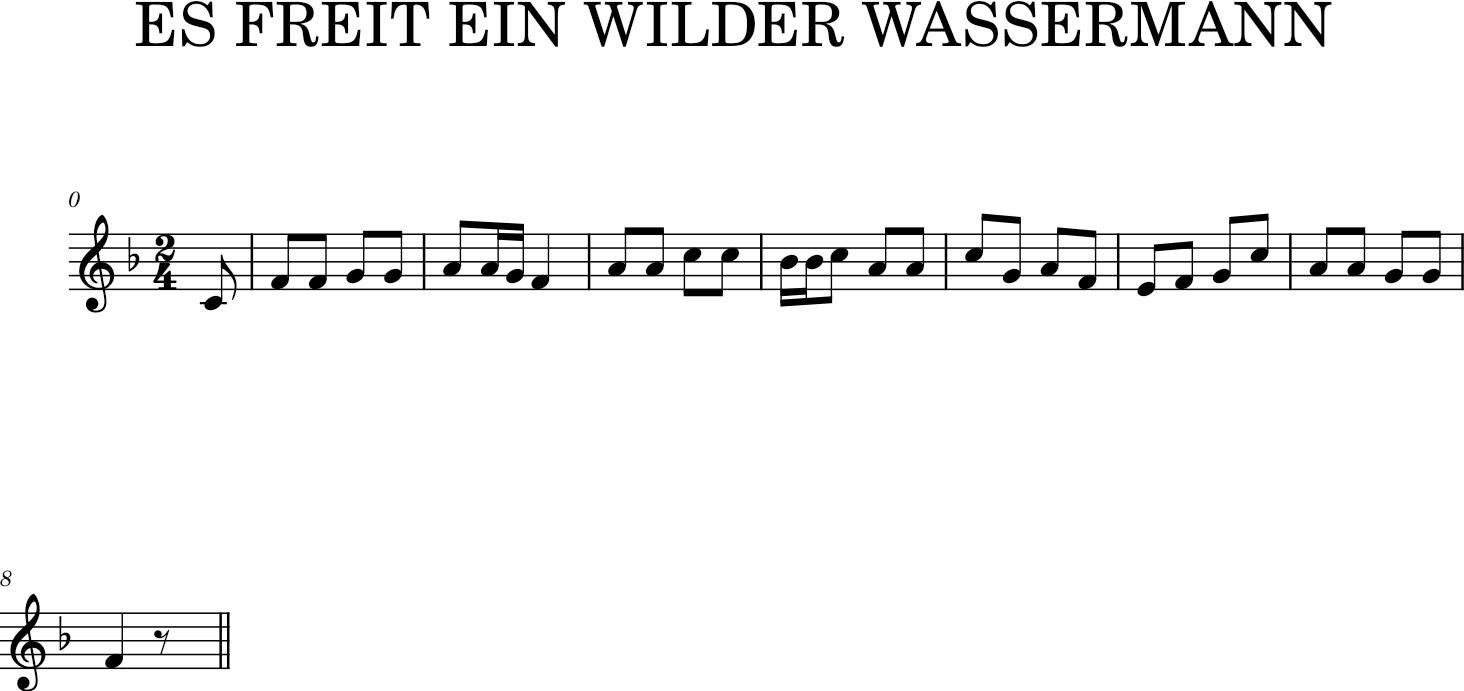

In [15]:
main()